# Project: Identify Customer Segments. Clustering.

In [ ]:
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 

%matplotlib inline

In [ ]:
df = pd.read_csv("Udacity_AZDIAS_Subset.csv",sep=";")
df = clean_data(df)

## Step 2: Feature Transformation

### Step 2.1: Feature Scaling

We will simply drop all the rows with the NaN values. We still have 625850 rows left:

In [44]:
len(df)

797837

In [45]:
df = df.dropna()
print(len(df))

625850


In [46]:
# Apply feature scaling to the general population demographics data.

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df)


### Step 2.2: Dimensionality Reduction

In [47]:
# Apply PCA to the data.
from sklearn.decomposition import PCA
pca = PCA()
X_pca = pca.fit_transform(X_scaled)


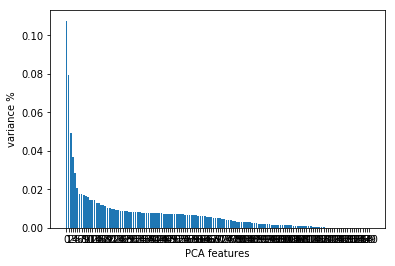

In [48]:
# Investigate the variance accounted for by each principal component.
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_)
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features)
plt.show()


In [49]:
###########helper function #######################
def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components=len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(10, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    for i in range(num_components):
        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')

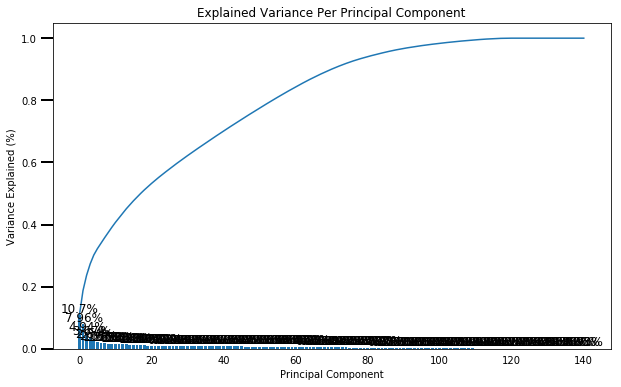

In [50]:
scree_plot(pca)

In [51]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca = PCA(n_components=60)
X_pca = pca.fit_transform(X_scaled)



In [52]:
sum(pca.explained_variance_ratio_)

0.83451533397632882

From the scree plot (variance explained plotted against the principal components) we see that the cumulative variability starts to slow down when we take more then 20 components. The growth slows down even more after 80 components or so. We will use first 60 components, this should account for the 84% of the data.

### Step 2.3: Interpret Principal Components

In [53]:
def plot_weights(i, df):
    arr = pca.components_[i]
    column_names = df.columns
    df_components = pd.DataFrame(arr, index = column_names).sort_values(0)
    a = pd.concat([df_components[:5], df_components[-5:]])
    a.columns = ["component_"+str(i)]
    a.plot.bar()

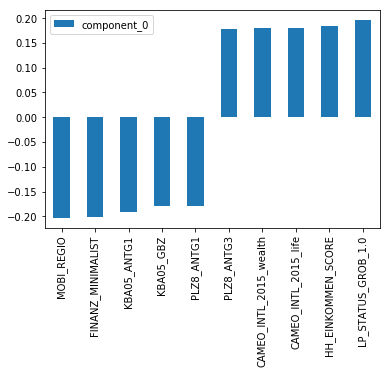

In [54]:
plot_weights(0,df)

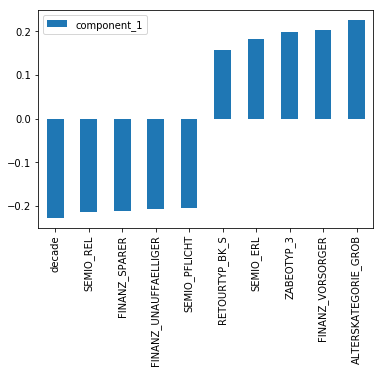

In [55]:
plot_weights(1,df)

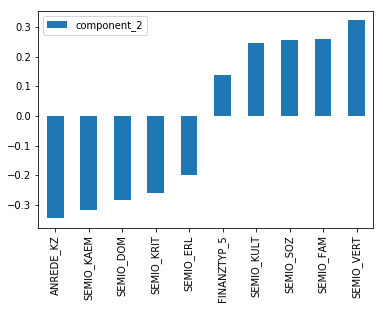

In [56]:
plot_weights(2,df)

The first component has negative weights from the following features: movement patterns, number of houses in the "microcell". At the same time, the social status was amongst the features with positive weights. <br>

The second component includes estimated age and financial typology. <br>

Third component is concerned with the personality typology (socially-minded, tradional-minded, etc).


## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

In [57]:
# The change in within-cluster distance across number of clusters.
from sklearn.cluster import KMeans

score = []
for i in range(1,10):
    model = KMeans(i)
    model.fit(X_pca)
    score.append(np.abs(model.score(X_pca)))
    
    

/opt/conda/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


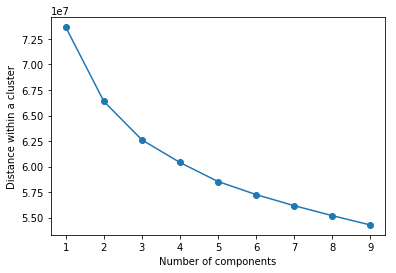

In [93]:
plt.plot(range(1,10),score,linestyle='-', marker='o',)
ax = plt.subplot()
ax.set_xticks(range(1,10))
ax.set_xticklabels(range(1,10))
plt.xlabel("Number of components")
plt.ylabel("Distance within a cluster")
plt.show()

In [83]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data
model = KMeans(8)
predictions_gen = model.fit_predict(X_pca)


### Discussion 3.1: Apply Clustering to General Population

We will use 8 clusters. There is no well-pronounced "elbow" on the above curve. 

### Step 3.2: Apply All Steps to the Customer Data


In [84]:
# Load in the customer demographics data
customers = pd.read_csv("Udacity_CUSTOMERS_Subset.csv",sep=";")

In [85]:
# Prepreprocessing, feature transformation, and clustering

data = clean_data(customers)

data = data.dropna()

In [86]:
data = scaler.fit_transform(data)

customers_pca = pca.transform(data)

predictions = model.predict(customers_pca)

### Step 3.3: Compare Customer Data to Demographics Data

In [87]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.


prediction_percent = []
for i in range(0,9):
    prediction_percent.append( (predictions==i).sum()*100/len(predictions))
    
predictions_gen_percent = []
for i in range(0,9):
    predictions_gen_percent.append( (predictions_gen==i).sum()*100/len(predictions_gen))
    
difference = []
for i in range(0,9):
    difference.append( (predictions==i).sum()*100/len(predictions) - \
    (predictions_gen==i).sum()*100/len(predictions_gen) )
    
    

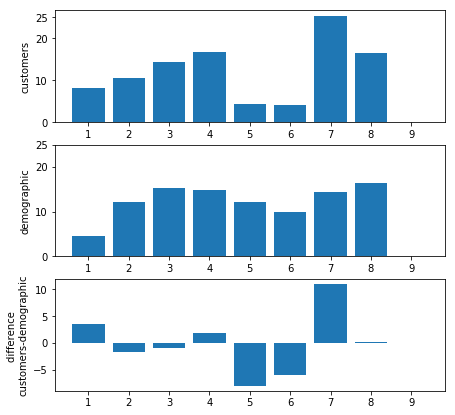

In [88]:
plt.figure(figsize = (7,7))

m = range(1,10)
plt.subplot(3,1, 1)
plt.bar(list(m), prediction_percent)
plt.ylabel("customers")
plt.xticks(m)
plt.yticks([0,10,20,25])

plt.subplot(3,1, 2)
plt.bar(list(m), predictions_gen_percent)
plt.ylabel("demographic")
plt.xticks(m)
plt.yticks([0,10,20,25])

plt.subplot(3,1, 3)
plt.bar(list(m), difference)
plt.ylabel("difference \ncustomers-demographic")
plt.xticks(m)

plt.show()


In [64]:
def plot_weights_clusters(i, df):
    arr = pca.inverse_transform(model.cluster_centers_[i])
    column_names = df.columns
    df_components = pd.DataFrame(arr, index = column_names).sort_values(0)
    a = pd.concat([df_components[:5], df_components[-5:]])
    a.columns = ["cluster"+str(i)]
    a.plot.bar()

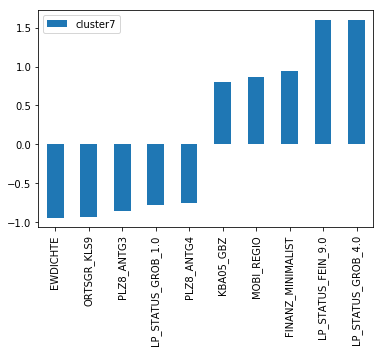

In [89]:
plot_weights_clusters(7,df)

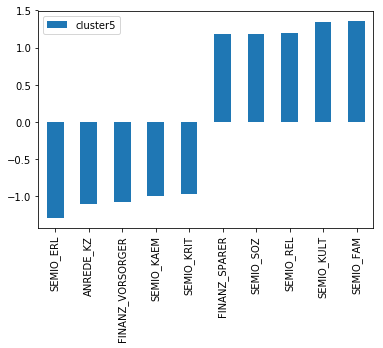

In [90]:
plot_weights_clusters(5,df)

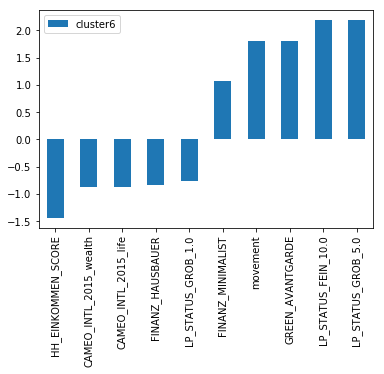

In [94]:
plot_weights_clusters(6,df)

What kinds of people are part of a cluster that is overrepresented in the
customer data compared to the general population?


Cluster number 7 has a larger proportion of customers compared to the general population. This cluster is characterized by the following features: <br>
(negative weights) density of households, size of communty <br>
(positive weights) house owners, top earners




What kinds of people are part of a cluster that is underrepresented in the
customer data compared to the general population?

Cluster number 5 has a larger proportion of the general population compared to customers. This cluster is characterized by the following features: <br>
(negative weights)   event-oriented  <br>
(positive weights)  family-minded, religious

### Customer Data vs Demographics Data


From the analysis we see that the mailing-order company is more popular (compared to the general population) amongst the high-income house owners. They typically live in a neighboorhod with a small community size. At the same time they are "mainstream" people and were not associated with any environmental group in their youth.

The company is not very popular amongst the family-minded, religious people with a low event-oriented profile. They prefer to save their money ("SPARER" type).
